In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

e:\Bootcamp\DS_Grupo3\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
current_dir = os.getcwd()

parent_dir = os.path.abspath(os.path.join(current_dir, "../.."))
folder_path = 'data'
file_name = 'train_stroke_woe_smote.csv'

file_path = os.path.join(parent_dir, folder_path, file_name)

df_train = pd.read_csv(file_path)

parent_dir = os.path.abspath(os.path.join(current_dir, "../.."))
folder_path = 'data'
file_name = 'test_stroke_woe_smote.csv'

file_path = os.path.join(parent_dir, folder_path, file_name)

df_test = pd.read_csv(file_path)

In [3]:
y_train = df_train['stroke']
X_train = df_train.drop(['stroke'], axis=1).astype(int)

y_test = df_test['stroke']
X_test = df_test.drop(['stroke'], axis=1).astype(int)

eval_set = [(X_train, y_train), (X_test, y_test)]

In [4]:
X = X_train
y = y_train

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 100, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 100, log=True),
        'random_state': 42,
        'eval_metric': 'logloss'
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1337)
    precision_scores = []
    f1_scores = []

    for train_index, test_index in skf.split(X, y):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        model = XGBClassifier(**params)
        model.fit(X_train_fold, y_train_fold, eval_set=[(X_test_fold, y_test_fold)], verbose=0)
    
        y_pred_fold = model.predict(X_test_fold)
        
        # Calculamos precision y F1-Score para la clase positiva (1)
        precision = precision_score(y_test_fold, y_pred_fold, pos_label=1)
        f1 = f1_score(y_test_fold, y_pred_fold, pos_label=1)
        
        precision_scores.append(precision)
        f1_scores.append(f1)
    
    # Promedio de precision y f1-score para el objetivo de Optuna
    precision_mean = sum(precision_scores) / len(precision_scores)
    f1_mean = sum(f1_scores) / len(f1_scores)
    
    return (precision_mean + f1_mean) / 2

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params

final_model = XGBClassifier(**best_params)
final_model.fit(X, y)

[I 2024-10-29 01:56:49,205] A new study created in memory with name: no-name-ccba6d5c-955e-481e-b106-126fd5675df0
[I 2024-10-29 01:56:50,849] Trial 0 finished with value: 0.7544792572479411 and parameters: {'n_estimators': 270, 'learning_rate': 0.03894350688482847, 'max_depth': 7, 'reg_alpha': 7.319702657302899e-05, 'reg_lambda': 1.2014677697753653}. Best is trial 0 with value: 0.7544792572479411.
[I 2024-10-29 01:56:52,583] Trial 1 finished with value: 0.7511183280361333 and parameters: {'n_estimators': 380, 'learning_rate': 0.17573454206030414, 'max_depth': 5, 'reg_alpha': 0.0017716940769827096, 'reg_lambda': 31.229263538663815}. Best is trial 0 with value: 0.7544792572479411.
[I 2024-10-29 01:56:53,280] Trial 2 finished with value: 0.7425631048968986 and parameters: {'n_estimators': 144, 'learning_rate': 0.06289290081866233, 'max_depth': 4, 'reg_alpha': 28.156610913605096, 'reg_lambda': 0.0012189018718226133}. Best is trial 0 with value: 0.7544792572479411.
[I 2024-10-29 01:56:54,90

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.29612995205724896,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=718, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [5]:
y_pred_final = final_model.predict(X_test)
accuracy_final = accuracy_score(y_test, y_pred_final)

cv_scores = cross_val_score(final_model, X, y, cv=5)
print(f"Puntajes de validación cruzada: {cv_scores}")
print(f"Media de los puntajes: {cv_scores.mean()}")

conf_matrix = confusion_matrix(y_test, y_pred_final)
class_report = classification_report(y_test, y_pred_final)

Puntajes de validación cruzada: [0.76121372 0.74802111 0.74802111 0.7671504  0.74868074]
Media de los puntajes: 0.7546174142480211


Precisión del modelo: 0.7392176529588766


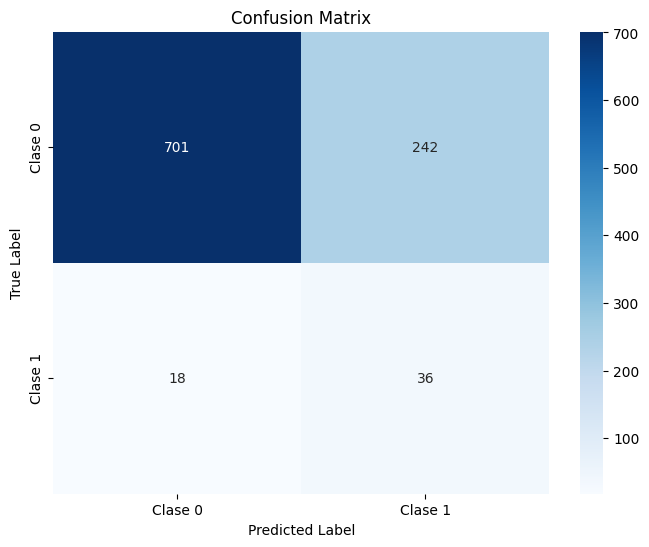

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.97      0.74      0.84       943
           1       0.13      0.67      0.22        54

    accuracy                           0.74       997
   macro avg       0.55      0.71      0.53       997
weighted avg       0.93      0.74      0.81       997



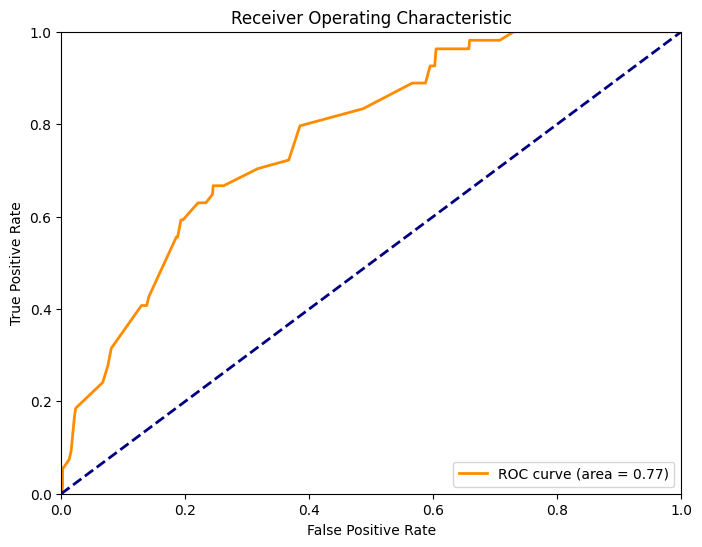

In [6]:
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Clase 0", "Clase 1"], yticklabels=["Clase 0", "Clase 1"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')


print(f"Precisión del modelo: {accuracy_final}")
plt.show()
print("Reporte de clasificación:\n", class_report)

y_prob = final_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [7]:
current_dir = os.getcwd()

parent_dir = os.path.abspath(os.path.join(current_dir, "../.."))
folder_path = 'data'
file_name = 'test_stroke_woe.csv'

file_path = os.path.join(parent_dir, folder_path, file_name)

df_test = pd.read_csv(file_path)

In [9]:
# Separar las características y la variable objetivo del conjunto de test
X_test_new = df_test.drop(['stroke'], axis=1).astype(int)
y_test_new = df_test['stroke']

# Predecir con el modelo final
y_pred_test_new = final_model.predict(X_test_new)
accuracy_test_new = accuracy_score(y_test_new, y_pred_test_new)

# Evaluar el modelo
conf_matrix_test_new = confusion_matrix(y_test_new, y_pred_test_new)
class_report_test_new = classification_report(y_test_new, y_pred_test_new)

# Mostrar resultados
print(f"Precisión del modelo en el conjunto de test: {accuracy_test_new}")
print("Matriz de confusión:\n", conf_matrix_test_new)
print("Reporte de clasificación:\n", class_report_test_new)

Precisión del modelo en el conjunto de test: 0.7392176529588766
Matriz de confusión:
 [[701 242]
 [ 18  36]]
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.97      0.74      0.84       943
           1       0.13      0.67      0.22        54

    accuracy                           0.74       997
   macro avg       0.55      0.71      0.53       997
weighted avg       0.93      0.74      0.81       997



Precisión del modelo: 0.7392176529588766


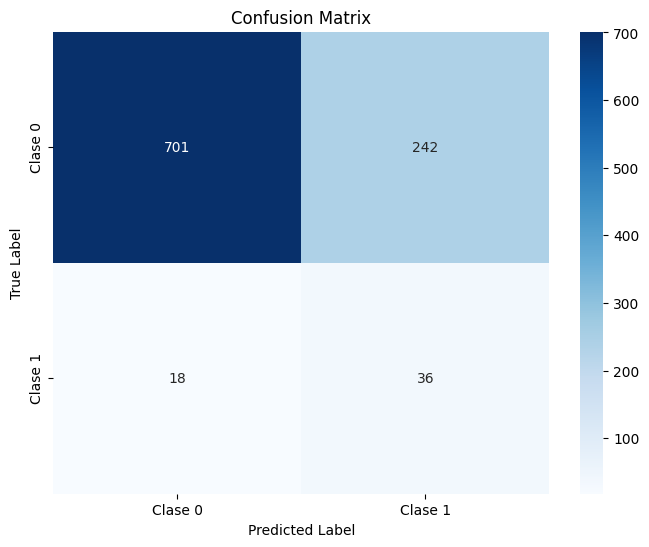

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.97      0.74      0.84       943
           1       0.13      0.67      0.22        54

    accuracy                           0.74       997
   macro avg       0.55      0.71      0.53       997
weighted avg       0.93      0.74      0.81       997



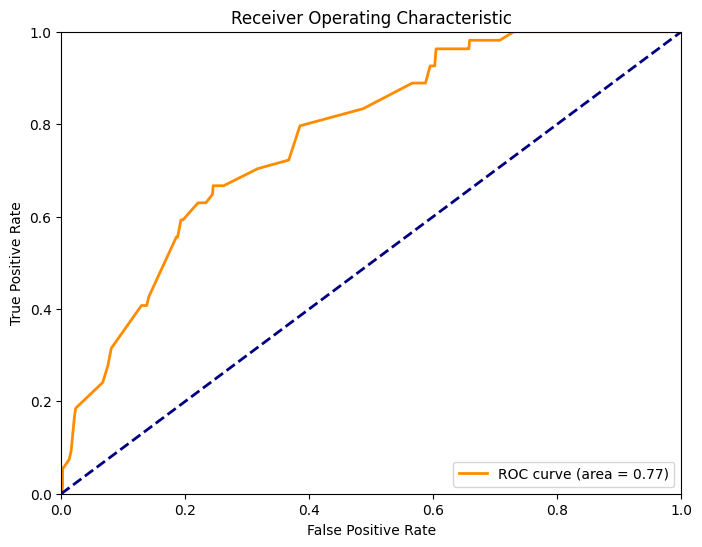

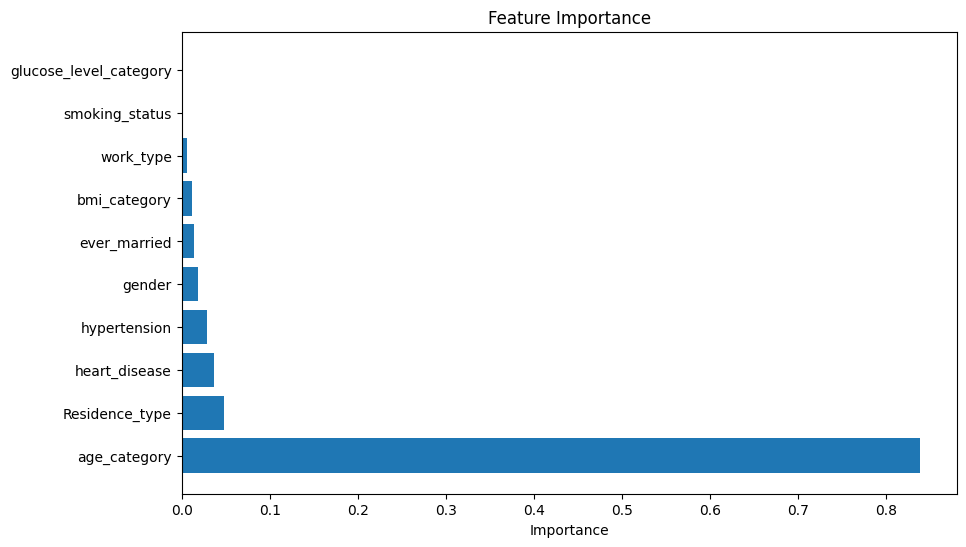

In [13]:
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_test_new, annot=True, fmt="d", cmap="Blues", xticklabels=["Clase 0", "Clase 1"], yticklabels=["Clase 0", "Clase 1"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')


print(f"Precisión del modelo: {accuracy_test_new}")
plt.show()
print("Reporte de clasificación:\n", class_report_test_new)

y_prob = final_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

importances = final_model.feature_importances_

# Crear un DataFrame para facilitar la visualización
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Graficar la importancia de las características
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()